In [10]:
from utils import *

import time
import numpy as np
import pandas as pd
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# import xgboost as xgb
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

def parser(x):
    return datetime.datetime.strptime(x,'%Y%m%d')

dataset_ex_df = pd.read_csv('data/panel_data_close.csv', header=0, parse_dates=[2], date_parser=parser)
# len(dataset_ex_df)
dataset_ex_df[['trade_date', 'close']].head(3)

print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2364 number of days in the dataset.


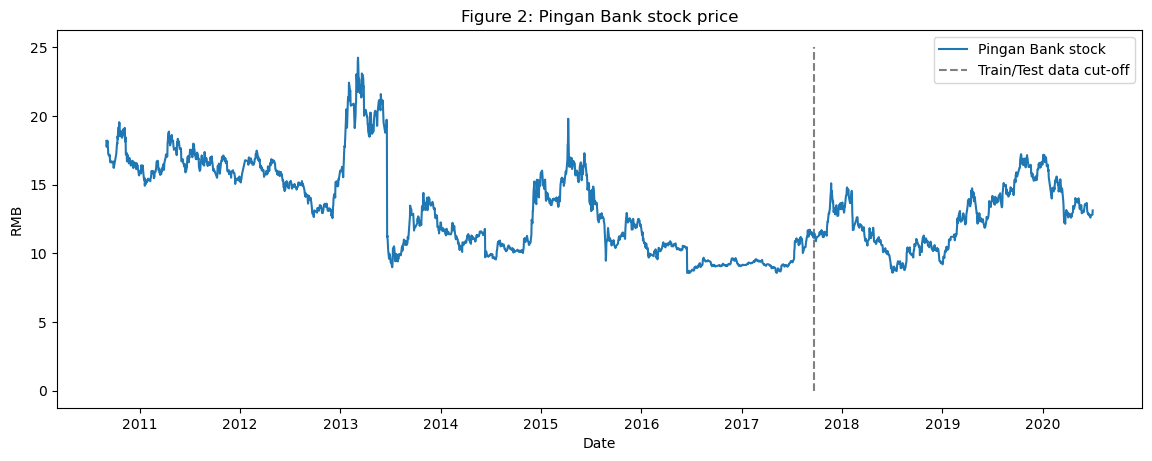

In [11]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['trade_date'], dataset_ex_df['close'], label='Pingan Bank stock')
plt.vlines(datetime.date(2017,9, 20), 0, 25, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('RMB')
plt.title('Figure 2: Pingan Bank stock price')
plt.legend()
plt.show()

In [12]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 1654. Number of test days: 710.


In [23]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['close'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['close'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['close']-1
    
    return dataset

dataset_TI_df = get_technical_indicators(dataset_ex_df)
dataset_TI_df.head()

,index,Unnamed: 0,ts_code,trade_date,open,high,low,close,pre_close,change,...,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,0,0,000001.SZ,2020-07-01,12.79,13.15,12.74,13.12,12.80,0.32,...,NaN,NaN,13.120000,13.120000,0.000000,NaN,NaN,NaN,13.120000,12.12
1,1,1,000001.SZ,2020-06-30,12.83,12.88,12.72,12.80,12.80,0.00,...,NaN,NaN,13.096296,13.070769,-0.025527,NaN,NaN,NaN,12.880000,11.80
2,2,2,000001.SZ,2020-06-29,12.92,12.97,12.71,12.80,12.80,0.00,...,NaN,NaN,13.074348,13.029112,-0.045236,NaN,NaN,NaN,12.824615,11.80
3,3,3,000001.SZ,2020-06-24,12.64,12.88,12.60,12.80,12.60,0.20,...,NaN,NaN,13.054026,12.993864,-0.060162,NaN,NaN,NaN,12.808000,11.80
4,4,4,000001.SZ,2020-06-23,12.65,12.69,12.52,12.60,12.64,-0.04,...,NaN,NaN,13.020395,12.933270,-0.087125,NaN,NaN,NaN,12.668760,11.60


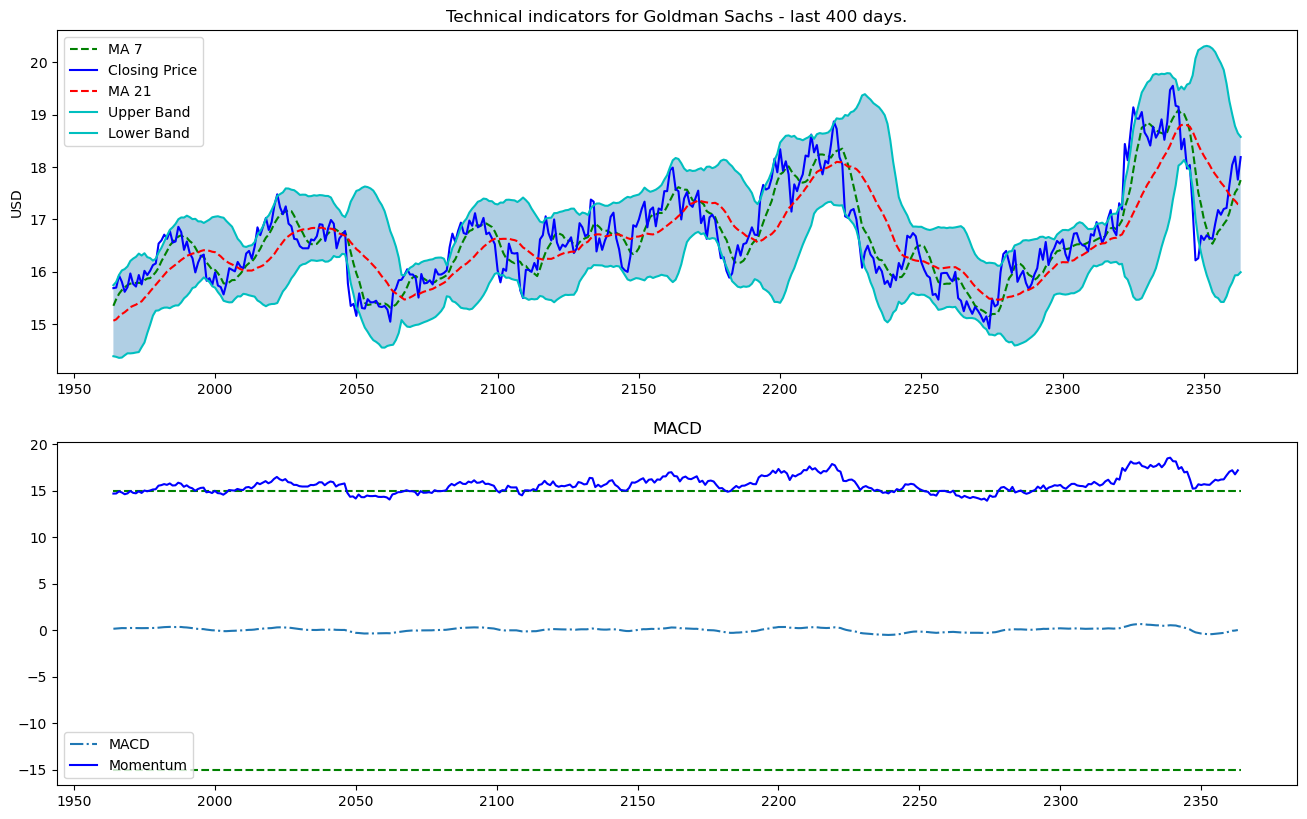

In [25]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()
    
plot_technical_indicators(dataset_TI_df, 400)

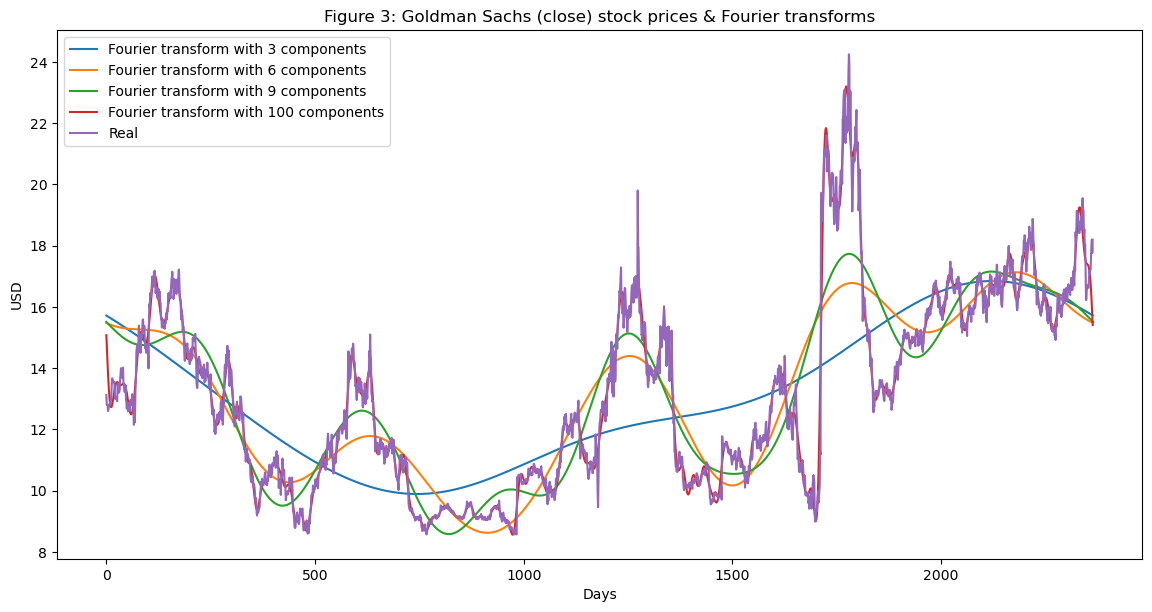

In [26]:
data_FT = dataset_ex_df[['trade_date', 'close']]

close_fft = np.fft.fft(np.asarray(data_FT['close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

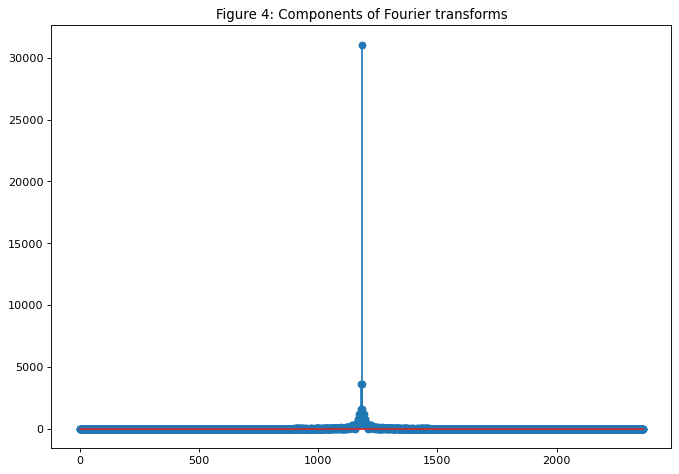

In [40]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [28]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 2363
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -893.052
Method:                       css-mle   S.D. of innovations              0.353
Date:                Fri, 27 Nov 2020   AIC                           1800.103
Time:                        17:36:54   BIC                           1840.477
Sample:                             1   HQIC                          1814.803
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.007      0.298      0.766      -0.012       0.016
ar.L1.D.close    -0.0141      0.021     -0.685      0.493      -0.054       0.026
ar.L2.D.close    -0.0061      0.021     

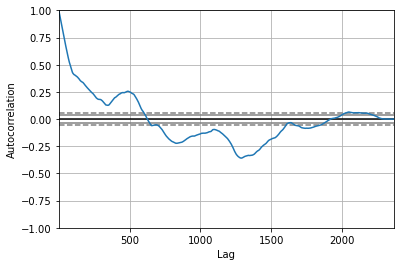

<Figure size 800x560 with 0 Axes>

In [30]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [32]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.212


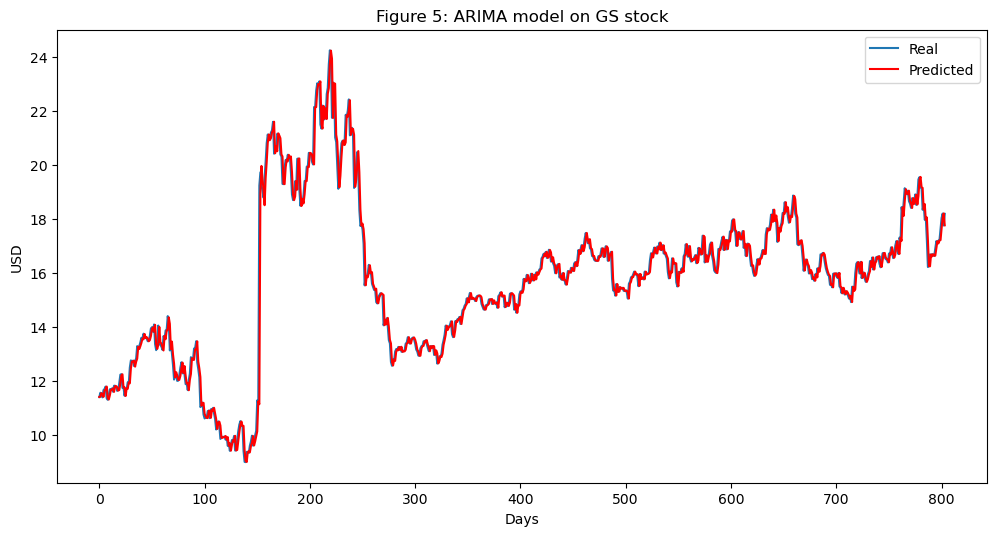

In [33]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('RMB')
plt.title('Figure 5: ARIMA model on Pingan Bank stock')
plt.legend()
plt.show()

In [36]:
print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], 
                                                              dataset_total_df.shape[1]))

NameError: name 'dataset_total_df' is not defined

In [39]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

import xgboost as xgb

# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(dataset_TI_df)
egressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

XGBoostError: XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed (vcomp140.dll or libgomp-1.dll for Windows, libomp.dylib for Mac OSX, libgomp.so for Linux and other UNIX-like OSes). Mac OSX users: Run `brew install libomp` to install OpenMP runtime.
  * You are running 32-bit Python on a 64-bit OS
Error message(s): ['dlopen(/Users/hanjie/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/hanjie/opt/anaconda3/lib/python3.8/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: image not found']
